<a href="https://colab.research.google.com/github/JpChii/ML-Projects/blob/main/09_skim_lit_40k_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [15]:
# Setting up extensions
%load_ext google.colab.data_table

The google.colab.data_table extension is already loaded. To reload it, use:
  %reload_ext google.colab.data_table


In [this notebook](https://github.com/JpChii/ML-Projects/blob/main/09_SkimLit_milestone_project.ipynb), Created and ran a series of experiments to find a model that's performaing well. The notebook uses these two papers below,

1. Where our data is coming from: [*PubMed 200k RCT: a Dataset for Sequential Sentence Classification in Medical Abstracts*](https://arxiv.org/abs/1710.06071)
2. Where our model is coming from: [*Neural networks for joint sentence
classification in medical paper abstracts*](https://arxiv.org/pdf/1612.05251.pdf).

In this notebook, we'll create and train our best model on the 200k dataset. If we can see any improvements.

# Creating and training our tribrid model on full 200k pubmed dataset

We're going to replicate the below architecture. Let's fix desired accuracy at 90%, if it's not performing up to the mark. we'll think of the next steps after that.

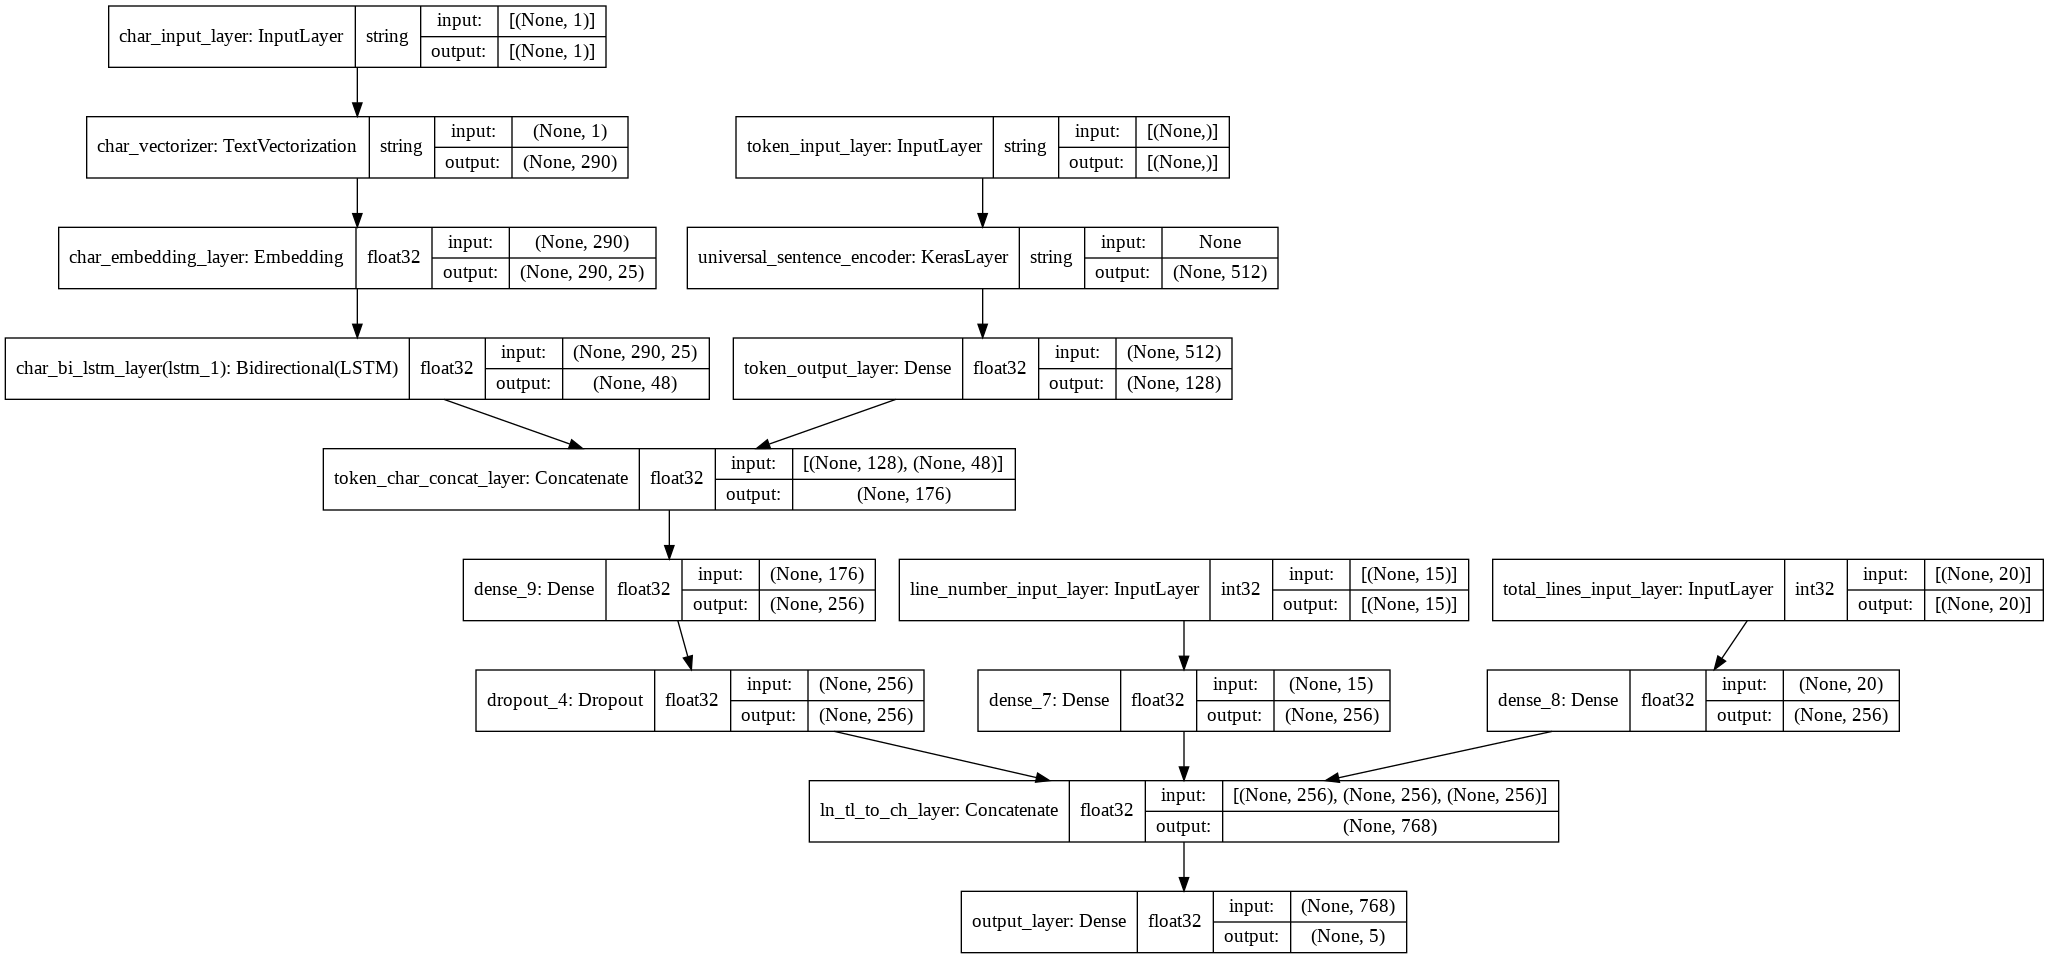

## Get the data

In the introduction section of the [dataset paper](https://arxiv.org/pdf/1710.06071.pdf) we can find the github link to download the data.

[Data github](https://github.com/Franck-Dernoncourt/pubmed-rct)

In [16]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct.git

fatal: destination path 'pubmed-rct' already exists and is not an empty directory.


### Get helper function

In [17]:
!wget https://raw.githubusercontent.com/JpChii/ML-Tools/main/dl_helper.py

--2021-06-10 15:10:57--  https://raw.githubusercontent.com/JpChii/ML-Tools/main/dl_helper.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 17973 (18K) [text/plain]
Saving to: ‘dl_helper.py.1’

dl_helper.py.1      100%[===================>]  17.55K  --.-KB/s    in 0s      

2021-06-10 15:10:57 (121 MB/s) - ‘dl_helper.py.1’ saved [17973/17973]



In [18]:
from dl_helper import walk_through_dir

In [19]:
# Checkout the cloned repo directory
!ls "/content/pubmed-rct"

PubMed_200k_RCT
PubMed_200k_RCT_numbers_replaced_with_at_sign
PubMed_20k_RCT
PubMed_20k_RCT_numbers_replaced_with_at_sign
README.md


Okay, so we have 20k and 200k dataset with two variants. In out parent notebook we've used `PubMed_20k_RCT_numbers_replaced_with_at_sign` and we'll use `PubMed_200k_RCT_numbers_replaced_with_at_sign` for comparison with previous models.

In [20]:
# Chekout the 200RCT data directory
walk_through_dir("/content/pubmed-rct/PubMed_200k_RCT_numbers_replaced_with_at_sign")

There are 0 directories and 4 images in '/content/pubmed-rct/PubMed_200k_RCT_numbers_replaced_with_at_sign'.


In [21]:
# Check the contents of the directory
!ls "/content/pubmed-rct/PubMed_200k_RCT_numbers_replaced_with_at_sign"

dev.txt  test.txt  train.txt  train.zip


We've three files for val(dev), train and test. Let's write some functions to preprocess these data.

## Preprocessing data

In this section we'll get the data from text file into pandas dataframe.

In [22]:
# Creating a function to read the document and put into a list
def get_lines(filename):
  """
  Reads a file and returns the lines of text as a list
  """

  with open(filename, "r") as f:
    return f.readlines()

In [23]:
def preprocess_text_with_line_numbers(filename):
  """
  Returns a lsit of dictionaries of abstract line data
  """

  # Get all the lines into a list
  input_lines = get_lines(filename)
  # Create an emty abstract
  abstract_lines = ""
  # Create an empty list of abstracts
  abstract_samples = []

  # Loo[ through each line in the target file
  for line in input_lines:
    if line.startswith("###"):
      abstract_id = line
      abstract_lines = "" # reset the abstract string in the line if it's an ID line
    elif line.isspace():
      abstract_line_split = abstract_lines.splitlines() # Split abstract into seperate lines

      # Iterate through each line in abstract lines and add line number and total lines
      for abstract_line_number, abstract_line in enumerate(abstract_line_split):
        line_data = {}
        target_text_split = abstract_line.split("\t") # Split the data since they are seperate by tab
        line_data["target"] = target_text_split[0]
        line_data["text"] = target_text_split[1].lower() # Get target text and lower it
        line_data["line_number"] = abstract_line_number
        line_data["total_lines"] = len(abstract_line_split) - 1
        abstract_samples.append(line_data)

    else:
      abstract_lines += line

  return abstract_samples

In [24]:
# Unzip train.zip
from dl_helper import unzip_data
unzip_data("/content/pubmed-rct/PubMed_200k_RCT_numbers_replaced_with_at_sign/train.zip")

In [25]:
train_dir = "/content/pubmed-rct/PubMed_200k_RCT_numbers_replaced_with_at_sign/"

In [26]:
!mv "/content/train.txt" "/content/pubmed-rct/PubMed_200k_RCT_numbers_replaced_with_at_sign"

In [27]:
# Let's read in the training data
train_dict = preprocess_text_with_line_numbers(train_dir + "train.txt")

In [28]:
# Get val and test data as well 
val_dict = preprocess_text_with_line_numbers(train_dir + "dev.txt")
test_dict = preprocess_text_with_line_numbers(train_dir + "test.txt")

In [29]:
# Check the length of the dict
len(train_dict), len(val_dict), len(test_dict)

(2211861, 28932, 29493)

We've got huge amount of data.

In [30]:
import pandas as pd
# Convert the data to pandas dataframes
train_df = pd.DataFrame(train_dict)
val_df = pd.DataFrame(val_dict)
test_df = pd.DataFrame(test_dict)

In [31]:
train_df.head()

,target,text,line_number,total_lines
0,BACKGROUND,the emergence of hiv as a chronic condition me...,0,10
1,BACKGROUND,this paper describes the design and evaluation...,1,10
2,METHODS,this study is designed as a randomised control...,2,10
3,METHODS,the intervention group will participate in the...,3,10
4,METHODS,the program is based on self-efficacy theory a...,4,10


After creating text vectorizer for character embedding and during `.adapt()`, method colab ran out of memory and kept crashing in the adapt cell. So we cannot traing the model with 200k dataset in free tier of colab even with GPU. So instead of full dataset. We'll go with 40% of the 200k dataset,

## Creating 40% PubMed dataset

In [32]:
from sklearn.model_selection import train_test_split
train_40_per_df, train_60_per_df = train_test_split(train_df, test_size=0.6)
val_40_per_df, val_60_per_df = train_test_split(val_df, test_size=0.6)
test_40_per_df, val_40_per_df = train_test_split(test_df, test_size=0.6)

In [33]:
len(train_df), len(train_40_per_df) + len(train_60_per_df), len(train_40_per_df), len(train_60_per_df)

(2211861, 2211861, 884744, 1327117)

## Turning data into numbers

Machine's hate text and love numbers, so right now our labels(`target`) and feature(`text`) are in text. We'll convert this to numbers.

In [34]:
# Distribution of labels in training daa
label_dist = pd.DataFrame(train_40_per_df.target.value_counts().reset_index())
label_dist

,index,target
0,RESULTS,307112
1,METHODS,288649
2,CONCLUSIONS,136159
3,BACKGROUND,78485
4,OBJECTIVE,74339


### Visualizing label distribution

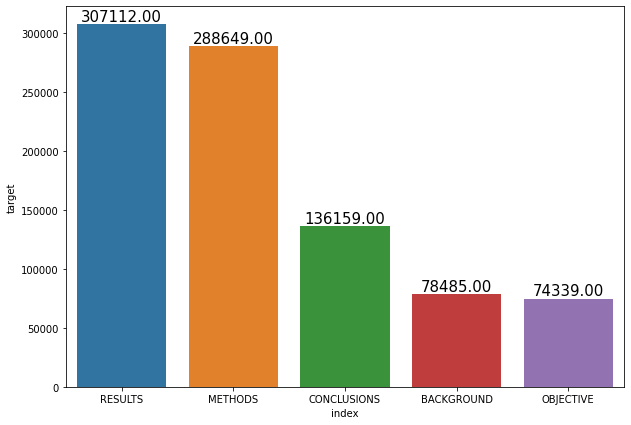

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(10,7))
plot = sns.barplot(x="index", y="target", data=label_dist)

# Iterating over bars one by one
for bar in plot.patches:
  plot.annotate(format(bar.get_height(), '.2f'), # gets the value
                (bar.get_x() + bar.get_width() / 2, bar.get_height()), # point in the plot fot text
                ha='center',
                va='center',
                size=15,
                xytext=(0,8),
                textcoords='offset points')
  
plt.show()

In [36]:
306557 / 74529

4.1132579264447395

There's a difference in labels but not huge like 10x or 100x only 4x.

### Turning our target label into numbers

We're going to one_hot encode our labels

In [37]:
# One-hot encode labels
from sklearn.preprocessing import OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse=False)

In [38]:
train_labels_one_hot = one_hot_encoder.fit_transform(train_40_per_df.target.to_numpy().reshape(-1,1)) # reshape(-1,1) we're asking numoy to determine the output shape of onehot encoding based on the categoricals
val_labels_one_hot = one_hot_encoder.transform(val_40_per_df.target.to_numpy().reshape(-1,1))
test_labels_one_hot = one_hot_encoder.transform(test_40_per_df.target.to_numpy().reshape(-1,1))

In [39]:
train_labels_one_hot[:5]

array([[0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0.]])

So, now the labels are converted to numbers. Next step is to convert text to numbers. The efficient way to convert learnable weights of our model is via embeddings.  Based on our best performing tribrid architecture. 

We need,

1. Token embeddings
      * For token embeddings we're going to use pretrained embeddings of `universal sentence encoder` from `TensorFlow Hub`. For this we just need a list of sentences.
2. Character embeddings
      * For character embedding, we're using custom embeddings layer. First we'll convert list of sentences to characters
      * Convert characters to integers using `TextVectorization`
      * Pass the vectors to `Custom embedding layer`
3. Positional embeddings
      * For positinal embeddings, we're gonna one-hot encode `line_number` and `total_lines` features.

Based on this the things we've to do next before proceesding with embeddings are,

1. Put sentences into a list
2. Convert sentencesw to characters


In [40]:
# Convert sentences into a list
train_sentences = train_40_per_df.text.to_list()
val_sentences = val_40_per_df.text.to_list()
test_sentences = test_40_per_df.text.to_list()

In [41]:
train_sentences[0]

'the use of osteoporosis pharmacotherapy or hip protectors improved by @ % in the intervention group and @ % in the control group , but the difference was not statistically significant ( p = @ ) .'

In [42]:
# Convert sentences to characters
def get_chars(text):
  return " ".join(list(text))

In [43]:
get_chars(train_sentences[0])

't h e   u s e   o f   o s t e o p o r o s i s   p h a r m a c o t h e r a p y   o r   h i p   p r o t e c t o r s   i m p r o v e d   b y   @   %   i n   t h e   i n t e r v e n t i o n   g r o u p   a n d   @   %   i n   t h e   c o n t r o l   g r o u p   ,   b u t   t h e   d i f f e r e n c e   w a s   n o t   s t a t i s t i c a l l y   s i g n i f i c a n t   (   p   =   @   )   .'

In [44]:
# Use the function and create chars list
train_chars = [get_chars(sentence) for sentence in train_sentences]
val_chars = [get_chars(sentence) for sentence in val_sentences]
test_chars = [get_chars(sentence) for sentence in test_sentences]
train_chars[0]

't h e   u s e   o f   o s t e o p o r o s i s   p h a r m a c o t h e r a p y   o r   h i p   p r o t e c t o r s   i m p r o v e d   b y   @   %   i n   t h e   i n t e r v e n t i o n   g r o u p   a n d   @   %   i n   t h e   c o n t r o l   g r o u p   ,   b u t   t h e   d i f f e r e n c e   w a s   n o t   s t a t i s t i c a l l y   s i g n i f i c a n t   (   p   =   @   )   .'

Now we've the list of sentences and characters

## Embeddings

Now we've all the stuff ready, let's create some embeddings

### Pretrained Token Embeddings

We'll use [Universal sentence encoder from tensorflow hub](https://tfhub.dev/google/universal-sentence-encoder/4)

In [45]:
import tensorflow_hub as hub
import tensorflow as tf
universal_sentence_encoder = hub.KerasLayer(handle="https://tfhub.dev/google/universal-sentence-encoder/4",
                                            trainable=False,
                                            input_shape=[],
                                            dtype=tf.string)

### Character Embeddings

For character embeddings, first we have to convert characters to numbers.

#### Character Vectorizer

In [46]:
# Let's get all the different characters
# Since we're going to strip punctuation and numbers are already replaced by @, We'll include only the alphabets and special characters for out max tokens size
import string
char_tokens = string.ascii_lowercase
char_tokens

'abcdefghijklmnopqrstuvwxyz'

In [47]:
len(char_tokens)

26

In [48]:
# LEt's get the output sequence length for vectorizer
import numpy as np
char_lens = [len(sentence) for sentence in train_sentences]
np.mean(char_lens)

147.83266119917172

In [49]:
char_lens[0], len(train_sentences[0]), len(train_chars[0]) # Length of train_chars won;t give us the correct length since we're joining each charcter with a space before it

(195, 195, 389)

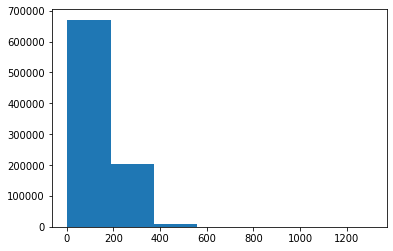

In [50]:
# Check the distribution of character length across sentences
plt.hist(char_lens, bins=7);

In [51]:
# Use percentile to find the length of 95%
output_char_seq_len =int(np.percentile(char_lens, 95))
output_char_seq_len

284

In [52]:
# Create vectorizer
NUM_CHAR_TOKENS = len(char_tokens) + 2
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
vectorizer_character = TextVectorization(max_tokens=NUM_CHAR_TOKENS,  # num chars in alphabets + space + oov
                                         output_sequence_length=output_char_seq_len,
                                         name="char_vectorizer_layer")

> **Note:** adapt() method on a dataset. When this layer is adapted, it will analyze the dataset, determine the frequency of individual string values, and create a 'vocabulary' from them. This vocabulary can have unlimited size or be capped, depending on the configuration options for this layer; if there are more unique values in the input than the maximum vocabulary size, the most frequent terms will be used to create the vocabulary.

In [53]:
%%time
# Adapt the text vectrorizer to train_chars
vectorizer_character.adapt(train_chars)

CPU times: user 3min 58s, sys: 4.12 s, total: 4min 2s
Wall time: 4min 1s


In [54]:
len(train_chars)

884744

In [55]:
# Check out the vocabulary
rct_80k_char_vocab = vectorizer_character.get_vocabulary()
print(f"Length of the vocabulay: {len(rct_80k_char_vocab)}")
print(f"Most frequent chars: {rct_80k_char_vocab[:5]}")
print(f"Least Frequent chars: {rct_80k_char_vocab[-5:]}")

Length of the vocabulay: 28
Most frequent chars: ['', '[UNK]', 'e', 't', 'a']
Least Frequent chars: ['k', 'x', 'z', 'q', 'j']


Now the vectorizer is done, let's create character embedding layer

#### Custom character Embedding

In [56]:
embedding_character = tf.keras.layers.Embedding(input_dim=len(rct_80k_char_vocab),
                                                output_dim=25, # IS the character embedding dimension used in the paper
                                                mask_zero=True)

Now token embedding and charcter embedding are done. Now let's next move onto positonal embeddings.

### Positional embedding

As Positional embedding, we alredy have the features `line_number` and `total_lines` as numerical. Let;s just one-hot encode them and move on to modelling.

1. One-hot encode line_number
2. One-hot enocde toal_line

#### One-Hot encode line_number

In [57]:
# Check the value counts of line number
train_40_per_df.line_number.value_counts()

2     76282
4     76203
3     76132
0     76002
1     75788
5     75711
6     74527
7     71312
8     65529
9     57434
10    47148
11    36280
12    26067
13    17861
14    11666
15     7516
16     4770
17     2944
18     1832
19     1263
20      785
21      506
22      344
23      207
24      169
25      119
26       82
27       59
28       46
29       36
30       29
31       21
32       20
33       10
34        9
35        7
37        4
36        4
41        3
44        3
40        3
43        2
48        2
39        2
42        1
38        1
46        1
47        1
49        1
Name: line_number, dtype: int64

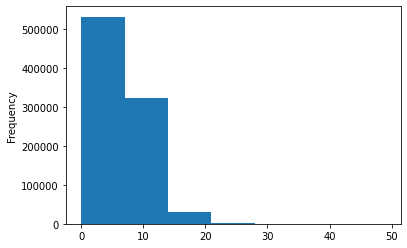

In [58]:
# Check the distribution
train_40_per_df.line_number.plot(kind="hist", bins=7);

In [59]:
# Check the 98 percentile to be used as the depth of the one-hot encoding
line_number_one_hot_depth = int(np.percentile(train_40_per_df.line_number, 98))
line_number_one_hot_depth

15

In [60]:
# One-hot encode
train_line_numbers_one_hot = tf.one_hot(train_40_per_df.line_number.to_numpy(), depth=line_number_one_hot_depth)
val_line_numbers_one_hot = tf.one_hot(val_40_per_df.line_number.to_numpy(), depth=line_number_one_hot_depth)
test_line_numbers_one_hot = tf.one_hot(test_40_per_df.line_number.to_numpy(), depth=line_number_one_hot_depth)
train_line_numbers_one_hot[:5]

<tf.Tensor: shape=(5, 15), dtype=float32, numpy=
array([[0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],
      dtype=float32)>

Now line number is completed, let's do the same for total lines.

#### One-Hot encode total_lines

In [61]:
# Check the value counts of total lines
train_40_per_df.total_lines.value_counts()

11    121754
10    121648
12    106530
9     103872
13     85020
8      73023
14     62732
15     44663
7      44252
16     30045
6      21241
17     19488
18     12580
19      8685
5       8358
20      5522
21      3983
4       2538
22      2278
23      1567
24      1114
25       779
26       587
3        478
27       450
28       353
29       300
33       189
31       155
32       108
30       107
35        70
34        65
36        55
37        40
43        22
49        20
50        16
40        16
45        16
46        15
2         10
Name: total_lines, dtype: int64

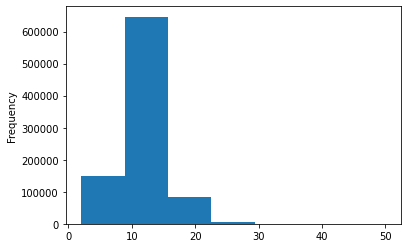

In [62]:
# Checkout the distribution
train_40_per_df.total_lines.plot(kind="hist", bins=7)

In [63]:
# Get the 98th percentile for one hot encode depth
total_lines_one_hot_encode_depth = int(np.percentile(train_40_per_df.total_lines, 98))
total_lines_one_hot_encode_depth

20

In [64]:
# Let's encode them
train_total_lines_one_hot = tf.one_hot(train_40_per_df.total_lines, depth=total_lines_one_hot_encode_depth)
val_total_lines_one_hot = tf.one_hot(val_40_per_df.total_lines, depth=total_lines_one_hot_encode_depth)
test_total_lines_one_hot = tf.one_hot(test_40_per_df.total_lines, depth=total_lines_one_hot_encode_depth)
train_total_lines_one_hot[:5]

<tf.Tensor: shape=(5, 20), dtype=float32, numpy=
array([[0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
        0., 0., 0., 0.]], dtype=float32)>

Now we've all the embeddings ready. Nex step is to prepate the data to be loaded efficiently into GPU's memory and fast training. Since we're dealing with huge data, we'll write some callbacks as well.

Next steps will be,

1. Setup Mixed precison - model layers will use lower precision whenever possible without affecting the numericaL stability
2. Build the model from our tribrid architecture
3. Create fast loading `tf.data.Dataset`
4. Train the model
5. Evaluate the model

## Modelling

### Setting up mixed precision

In [65]:
policy = tf.keras.mixed_precision.Policy("mixed_float16")
tf.keras.mixed_precision.set_global_policy(policy)

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: Tesla T4, compute capability 7.5


INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: Tesla T4, compute capability 7.5


### Building the model

In [66]:
# Imports
from tensorflow.keras import layers

In [67]:
# 1. Token level model
token_inputs = layers.Input(shape=[], dtype=tf.string, name="token_input_layer") # Input shape is list because unviersal sentence encoder accepts a list of sentences and return 512 dimension embedding
embeds_token = universal_sentence_encoder(token_inputs)
token_outputs = layers.Dense(128, activation="relu", name="token_output_layer")(embeds_token)
token_model = tf.keras.Model(inputs=token_inputs,
                             outputs=token_outputs,
                             name="token_level_model")

In [68]:
# 2. Character level model
char_input = layers.Input(shape=(1, ), dtype=tf.string, name="char_input_layer")
vectors_char = vectorizer_character(char_input)
embeds_char = embedding_character(vectors_char)
char_bi_lstm = layers.Bidirectional(layers.LSTM(24))(embeds_char)
char_model = tf.keras.Model(inputs=char_input,
                            outputs=char_bi_lstm,
                            name="char_level_model")

In [69]:
# 3. Line number mode
line_number_input = layers.Input(shape=(line_number_one_hot_depth,), dtype=tf.float16, name="line_no_input_layer")
line_number_output = layers.Dense(256, activation="relu", name="line_no_output_layer")(line_number_input)
line_number_mode = tf.keras.Model(inputs=line_number_input,
                                  outputs=line_number_output,
                                  name="line_no_model")

In [70]:
# 4. Total lines model
total_lines_input = layers.Input(shape=(total_lines_one_hot_encode_depth,), dtype=tf.float16, name="total_lines_input_layer")
total_lines_output = layers.Dense(256, activation="relu", name="total_lines_output_layer")(total_lines_input)
total_lines_model = tf.keras.Model(inputs=total_lines_input,
                                   outputs=total_lines_output,
                                   name="total_lines_model")

In [71]:
# 5. Concatenate token level and character level outputs
z = layers.Concatenate(name="token_char_concat_layer")([token_model.output, char_model.output])

In [72]:
# 6. Add a dense layer and droput as mentioned in the paper after concatenation
z = layers.Dense(256, activation="relu")(z)
z = layers.Dropout(0.5)(z) # dropout layer for regulariation(to prevent overfitting, forcing the model to learn different paths to desired output)

In [73]:
# 7. Concatenate lineno and totalline output with z
ln_tl_to_ch_concat = layers.Concatenate(name="token_char_ln_tl_concat_layer")([line_number_mode.output, total_lines_model.output, z])

In [74]:
# 8. We'll have the activation layers seperate for numerical stability
x = layers.Dense(5, name="final_dense_layer")(ln_tl_to_ch_concat)
output_layer = layers.Activation(activation="softmax", name="output_layer", dtype=tf.float32)(x)

In [75]:
# 9. Building the model
model = tf.keras.Model(inputs=[token_model.input, char_model.input, line_number_mode.input, total_lines_model.input],
                       outputs=output_layer)

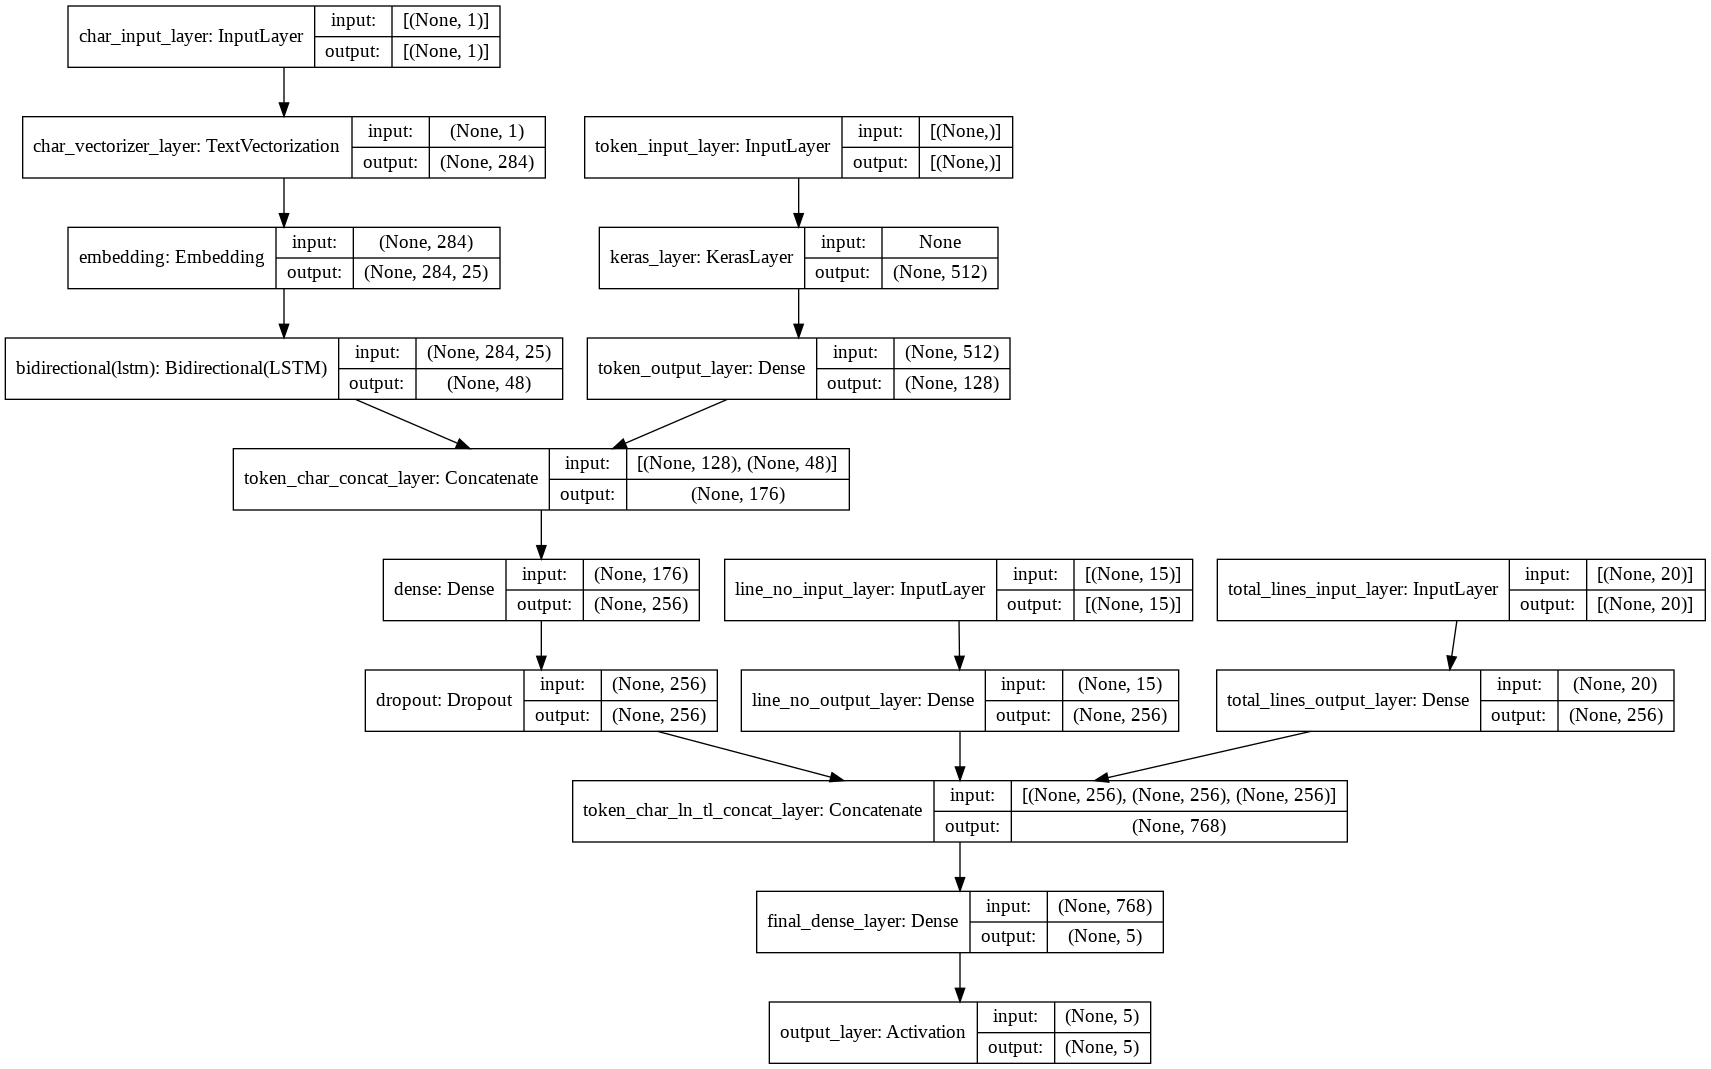

In [76]:
# Checkout the model architecture
from tensorflow.keras.utils import plot_model
plot_model(model, show_shapes=True, show_layer_names=True)

Look at the beautiful tribrid mode architecture. Now all left is to prepare the dataset and callbacks before training.

## Creating `tf.data` Dataset

The dataset should have the same order the inputs passed to the model.

First we'll convert our data to tensors. We converted our data to list and array for this purpose

In [77]:
# First data
train_to_ch_ln_tl_data = tf.data.Dataset.from_tensor_slices((train_sentences, train_chars, train_line_numbers_one_hot, train_total_lines_one_hot))
val_to_ch_ln_tl_data = tf.data.Dataset.from_tensor_slices((val_sentences, val_chars, val_line_numbers_one_hot, val_total_lines_one_hot))
test_to_ch_ln_tl_data = tf.data.Dataset.from_tensor_slices((test_sentences, test_chars, test_line_numbers_one_hot, test_total_lines_one_hot))

Created a tuple of `(sentencs, chars, line_number, total_lines)` for train, test, val.

Next is the label, label is common for all these four data. Let's create that next

In [78]:
# Labels
train_to_ch_ln_tl_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot)
val_to_ch_ln_tl_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
test_to_ch_ln_tl_labels = tf.data.Dataset.from_tensor_slices(test_labels_one_hot)

In [79]:
# Now let's zip data and label together into a single tuple
train_to_ch_ln_tl_dataset = tf.data.Dataset.zip(datasets=(train_to_ch_ln_tl_data, train_to_ch_ln_tl_labels))
val_to_ch_ln_tl_dataset = tf.data.Dataset.zip(datasets=(val_to_ch_ln_tl_data, val_to_ch_ln_tl_labels))
test_to_ch_ln_tl_dataset = tf.data.Dataset.zip(datasets=(test_to_ch_ln_tl_data, test_to_ch_ln_tl_labels))

train_to_ch_ln_tl_dataset

<ZipDataset shapes: (((), (), (15,), (20,)), (5,)), types: ((tf.string, tf.string, tf.float32, tf.float32), tf.float64)>

In [80]:
model.input_shape

[(None,), (None, 1), (None, 15), (None, 20)]

In [81]:
# Converint ZipDataset to Prefetch dataset
train_to_ch_ln_tl_dataset = train_to_ch_ln_tl_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
val_to_ch_ln_tl_dataset = val_to_ch_ln_tl_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_to_ch_ln_tl_dataset = test_to_ch_ln_tl_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [82]:
train_to_ch_ln_tl_dataset

<PrefetchDataset shapes: (((None,), (None,), (None, 15), (None, 20)), (None, 5)), types: ((tf.string, tf.string, tf.float32, tf.float32), tf.float64)>

Now Dataset is also created, only creation of callbacks is left.

## Creation of callbacks

In [83]:
# Tensorboard callback for logging
from dl_helper import create_tensorboard_callback

In [84]:
# Checkpoint callback
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath="/content/drive/MyDrive/ML_checkpoints/09_skimlit/40_per/",
                                                         monitor="val_accuracy",
                                                        verbose=1,
                                                         save_best_only=True,
                                                         save_weights_only=True)

In [85]:
# Early stopping callback
ealy_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy",
                                                          patience=3,
                                                          verbose=1)

In [86]:
# Reductin on plateau callback
rl_callback = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",
                                                   factor=0.2,
                                                   patience=3,
                                                   verbose=1,
                                                   min_lr=1e-7)

Now all the stuff are done, all left is to compile and train the model.

In [87]:
from dl_helper import save_model

In [88]:
# Compile the mode
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2),
             optimizer=tf.keras.optimizers.Adam(),
             metrics=["accuracy"])

In [ ]:
# Fit the model
history = model.fit(train_to_ch_ln_tl_dataset,
                    epochs=10,
                    validation_data=val_to_ch_ln_tl_dataset,
                    callbacks=[create_tensorboard_callback(dir_name="/content/drive/MyDrive/ML_logs/09_skimlit",
                                                           experiment_name="tribrid_model_40k_dataset"),
                               checkpoint_callback,
                               ealy_stopping_callback,
                               rl_callback])

Saving TensorBoard log files to: /content/drive/MyDrive/ML_logs/09_skimlit/tribrid_model_40k_dataset/20210610-151546
Epoch 1/10
27649/27649 [==============================] - 1304s 47ms/step - loss: 0.9096 - accuracy: 0.8512 - val_loss: 0.8864 - val_accuracy: 0.8649

Epoch 00001: val_accuracy improved from -inf to 0.86488, saving model to /content/drive/MyDrive/ML_checkpoints/09_skimlit/40_per/
Epoch 2/10
27649/27649 [==============================] - 1287s 47ms/step - loss: 0.8889 - accuracy: 0.8654 - val_loss: 0.8786 - val_accuracy: 0.8723

Epoch 00002: val_accuracy improved from 0.86488 to 0.87234, saving model to /content/drive/MyDrive/ML_checkpoints/09_skimlit/40_per/
Epoch 3/10
27649/27649 [==============================] - 1297s 47ms/step - loss: 0.8809 - accuracy: 0.8709 - val_loss: 0.8763 - val_accuracy: 0.8723

Epoch 00003: val_accuracy did not improve from 0.87234
Epoch 4/10
27649/27649 [==============================] - 1290s 47ms/step - loss: 0.8759 - accuracy: 0.8743 - va

So training on 40 percent data, we got only 2 percent increase in accuracy with huge increase in training time compared with the previous notebook using 10 percent data. This excercise might've been futile considering we've increased the data 3x. But let's save the model for the time being as it's performing the best for future use. And we also need to change the callbacks to e

In [ ]:
for layer in model.layers:
  print(layer.name, layer.dtype_policy, layer.compute_dtype)

In [ ]:
!nvidia-smi -L